## Imports

In [29]:
###############################################################################
#               Import part
###############################################################################
import tpknnsource as ks
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import neighbors, model_selection
from sklearn.base import BaseEstimator, ClassifierMixin 
import seaborn as sns
from matplotlib.colors import ListedColormap
import math
from sklearn.neighbors import KNeighborsClassifier
import warnings
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

In [2]:
###############################################################################
#               Additional functions
###############################################################################
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Génération artificielle de données

1) Étudiez les fonctions rand_bi_gauss, rand_tri_gauss, rand_clown et rand_checkers. Que renvoient ces fonctions ? 

Chacune de ces fonctions renvoie un double jeu de données: une matrice $X$ qui renvoie les variables explicatives ou features du modèle (une ligne par observation), et un vecteur $y$ qui renvoie les étiquettes correspondant à ces observations.

À quoi correspond la dernière colonne ? 

La dernière colonne (le vecteur $y$) correspond aux étiquettes. Ce sont des étiquettes binaires (1 ou -1) pour les jeux de données 1 et 3, et des étiquettes ternaires (1, 2 ou 3) pour les jeux de données 2 et 4.

Générez les données en utilisant chaque de ces 4 fonctions avec les paramètres du corrigé du TP1 (pour rand_checkers prenez 150 pour les deux premiers arguments ; pour rand_tri_gauss générez 50 observations dans chaque classe, centrées en (1, 1)> , (−1, −1)> et (1, −1)> , tous les écart-types égaux à 0.9). On va nommer ces jeux de données #1, #2, #3 et #4, respectivement.

In [3]:
# création des données avec les 4 fonctions tour à tour
# pour chaque fonction, on reprend les paramètres du corrigé du TP1 sur le perceptron, comme demandé

# premier jeu de données
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
X1, y1 = ks.rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)

# second jeu de données
n1 = 50
n2 = 50
n3 = 50
mu1 = [1., 1.]
mu2 = [-1., -1.]
mu3 = [1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
sigmas3 = [0.9, 0.9]
X2, y2 = ks.rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigmas1, sigmas2, sigmas3)

# troisième jeu de données
n1 = 50
n2 = 50
sigmas1 = 1.
sigmas2 = 5.
X3, y3 = ks.rand_clown(n1, n2, sigmas1, sigmas2)

# quatrième jeu de données
n1 = 150
n2 = 150
sigma = 0.1
X4, y4 = ks.rand_checkers(n1, n2, sigma)

2) Utilisez la fonction plot_2d afin d’afficher les jeux de données générés avec chacune des fonctions.

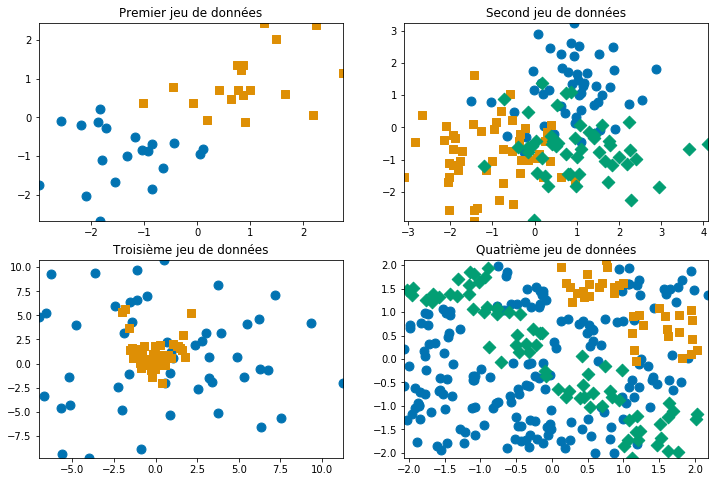

In [28]:
plt.close("all")
plt.figure(figsize=(12, 8))
# graphique du premier jeu de données
plt.subplot(221)
plt.title('Premier jeu de données')
ks.plot_2d(X1, y1)
# graphique du second jeu de données
plt.subplot(222)
plt.title('Second jeu de données')
ks.plot_2d(X2, y2)
# graphique du troisième jeu de données
plt.subplot(223)
plt.title('Troisième jeu de données')
ks.plot_2d(X3, y3)
# graphique du quatrième jeu de données
plt.subplot(224)
plt.title('Quatrième jeu de données')
ks.plot_2d(X4, y4)
plt.show()

# La méthode des k-plus proches voisins

3) Proposez une version adaptée de cette méthode pour la régression, i.e., quand les observations y sont à valeurs réelles : Y = R.

Pour la régression, on peut utiliser les k-plus proches voisins en terms d'observations $y$. Pour chaque nouveau point $y$, on calcule la distance (par exemple la distance euclidienne) entre $y$ et l'ensemble des observations de l'échantillon. On obtient alors $V_k(y)$, l'ensemble des k-plus proches voisins de $y$. On ne peut pas prendre la classe majoritaire ici car $y$ est une variable réelle continue. On peut en revanche aisément adapter la méthode en prenant comme valeur pour $y$ la moyenne des valeurs des k-plus proches voisins. on peut éventuellement aller plus loin et appliquer une distance non-euclidienne, ou une moyenne autre que la moyenne arithmétique.

## Approche formelle

4) Écrivez votre propre classe KNNClassifier avec les méthodes d’apprentissage fit et de classification predict.

In [5]:
class KNNClassifier(BaseEstimator, ClassifierMixin): 
    """ Homemade kNN classifier class """ 
    def __init__(self, n_neighbors=1): 
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y): 
        self.x = X
        self.y = y
        return self
        
    def predict(self, X):
        # fonction de distance (distance euclidienne)
        def dist(x,y):
            return math.sqrt(sum((x-y)**2))
        # calcul des distances entre chaque observation de X et les points de self.x
        rows_X = X.shape[0]
        pred = np.zeros(rows_X)
        rows_self = self.x.shape[0]
        for i in range (rows_X):
            x1 = X[i,:]
            dst = np.zeros(rows_self)
            for j in range (rows_self):
                x2 = self.x[j,:]
                dst[j] = dist(x1,x2)
            # indice des étiquettes les plus courantes
            indices = np.argsort(dst)
            k_indices = indices[:self.n_neighbors]
            k_labels = self.y[k_indices]
            l1, l2 = np.unique(k_labels, return_counts=True)
            # décision à la rgèle majoritaire
            label = l1[np.argmax(l2)]
            pred[i] = label
        return pred
         

Vérifier la validité des résultats en les comparant à ceux de la classe KNeighborsClassifier de scikit-learn en utilisant le jeu de données #2.

In [31]:
# je travaille sur le jeu de données #2, utilisant une moitié du jeu pour l'entrainement 
# et la seconde moitié pour le test

# j'utilise d'abord ma classe
clf = KNNClassifier(n_neighbors=5)
clf.fit(X2[::2], y2[::2])
clf_pred = clf.predict(X2[1::2])
print("Les étiquettes prédites par ma classe sont:")
print(clf_pred)

# comparaison avec scikit learn
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X2[::2], y2[::2])
clfsk_pred = clf.predict(X2[1::2])
print("Les étiquettes prédites par scikit learn sont:")
print(clfsk_pred)

# correspondance entre les deux prédicteurs
print("Les étiquettes correspondent-elles entre les deux méthodes?")
print(clf_pred == clfsk_pred)

Les étiquettes prédites par ma classe sont:
[2. 1. 3. 1. 1. 1. 2. 1. 2. 2. 3. 3. 3. 2. 3. 2. 1. 3. 2. 3. 3. 2. 2. 3.
 3. 3. 3. 1. 3. 2. 1. 3. 2. 3. 2. 2. 1. 2. 3. 3. 3. 1. 3. 1. 1. 2. 3. 2.
 3. 3. 2. 3. 2. 1. 2. 2. 3. 3. 1. 1. 3. 3. 1. 3. 3. 1. 2. 2. 2. 1. 3. 3.
 3. 1. 2.]
Les étiquettes prédites par scikit learn sont:
[2. 1. 3. 1. 1. 1. 2. 1. 2. 2. 3. 3. 3. 2. 3. 2. 1. 3. 2. 3. 3. 2. 2. 3.
 3. 3. 3. 1. 3. 2. 1. 3. 2. 3. 2. 2. 1. 2. 3. 3. 3. 1. 3. 1. 1. 2. 3. 2.
 3. 3. 2. 3. 2. 1. 2. 2. 3. 3. 1. 1. 3. 3. 1. 3. 3. 1. 2. 2. 2. 1. 3. 3.
 3. 1. 2.]
Les étiquettes correspondent-elles entre les deux méthodes?
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True

On voit que les deux classificateurs forment les même prédictions sur le jeu de données #2.

5) Faites tourner sur les quatre exemples de jeu de données cet algorithme de classification, en utilisant la distance euclidienne classique d(x, v) = kx − vk2 et k = 5. Visualisez les règles de classification obtenues en utilisant la fonction frontiere_new. (Souvent, les autres choix de distance peuvent être utiles, par exemple la distance de Mahalanobis.)

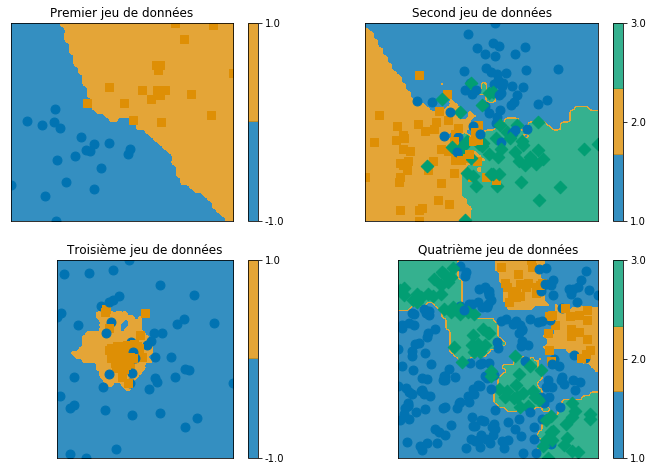

In [33]:
# traçage de la frontière, avec k=5
matplotlib_axes_logger.setLevel('ERROR')
def f(xx):
    return clf.predict(xx.reshape(1,-1))
plt.close("all")
plt.figure(figsize=(12, 8))
# frontière du premier jeu de données
clf.fit(X1, y1)
plt.subplot(221)
plt.title('Premier jeu de données')
ks.frontiere_new(f, X1, y1)
# frontière du second jeu de données
clf.fit(X2, y2)
plt.subplot(222)
plt.title('Second jeu de données')
ks.frontiere_new(f, X2, y2)
# frontière du troisième jeu de données
clf.fit(X3, y3)
plt.subplot(223)
plt.title('Troisième jeu de données')
ks.frontiere_new(f, X3, y3)
# frontière du quatrième jeu de données
clf.fit(X4, y4)
plt.subplot(224)
plt.title('Quatrième jeu de données')
ks.frontiere_new(f, X4, y4)
plt.show()

6) Pour les observations d’indice pair du jeu de données #2, faites varier le nombre k de voisins pris en compte : k = 1, 2, . . . , n.

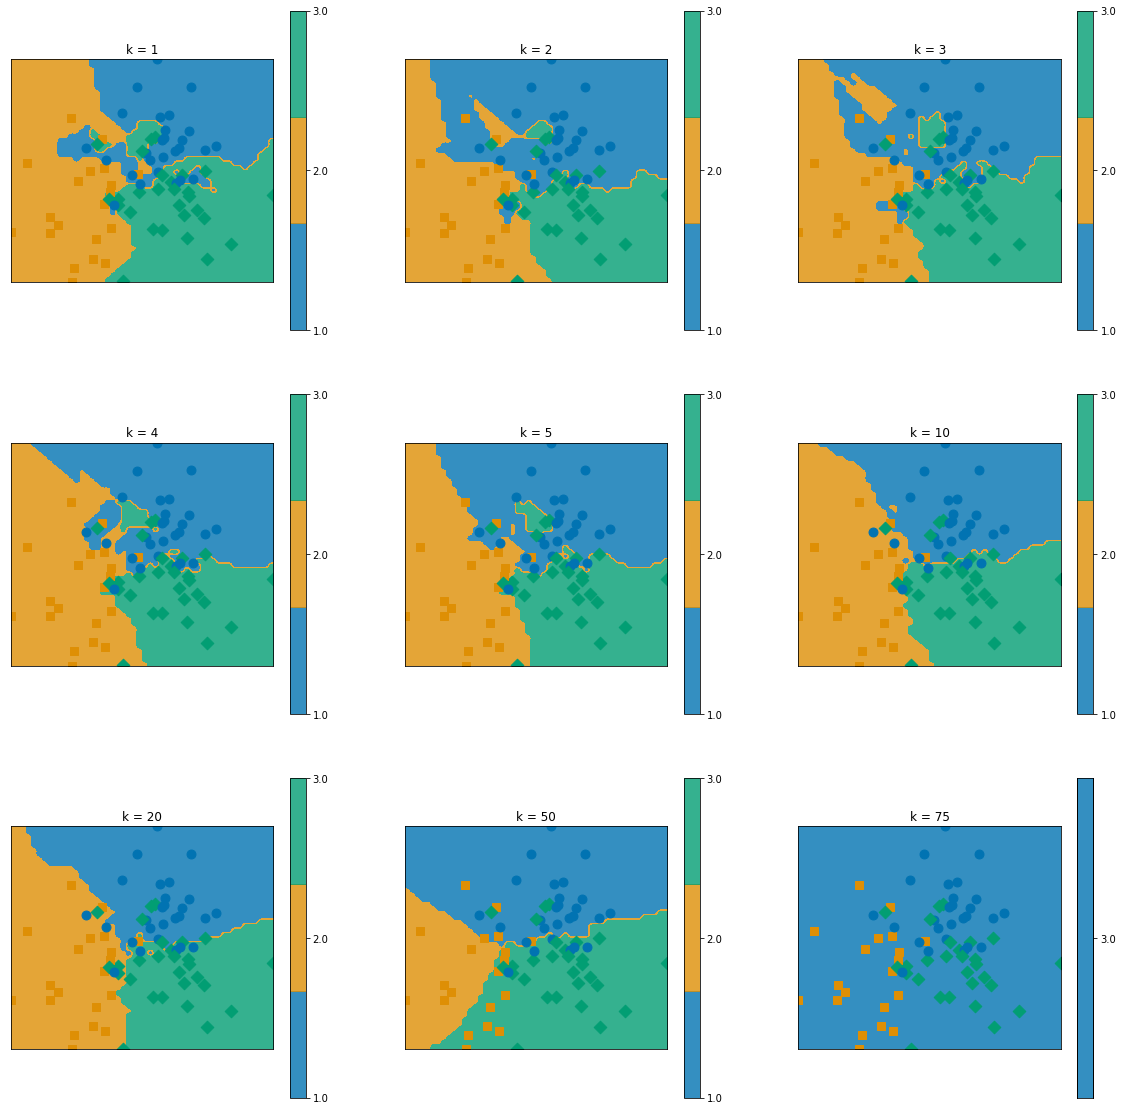

In [35]:
# on fait varier le nombre de voisins pris en compte, en examinant k=1, 2, 3, 4, 5, 10, 20, 50, et n (ici n=75)
plt.close("all")
plt.figure(figsize=(20, 20))
for count, k in enumerate([1, 2, 3, 4, 5, 10, 20, 50, 75]):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X2[::2], y2[::2])
    plt.subplot(int("33" + str(count+1)))
    plt.title('k = ' + str(k))
    ks.frontiere_new(f, X2[::2], y2[::2])

On remarque que plus le nombre de voisins $k$ est grand, plus la frontière tend à se simplifier.

Que devient la méthode dans le cas extrême où k = 1 ? k = n ? Afficher ces cas sur les données étudiées en utilisant la fonction frontiere_new et présentez les dans une forme facilement lisible. Dans quels cas la frontière est-elle complexe ? simple ?

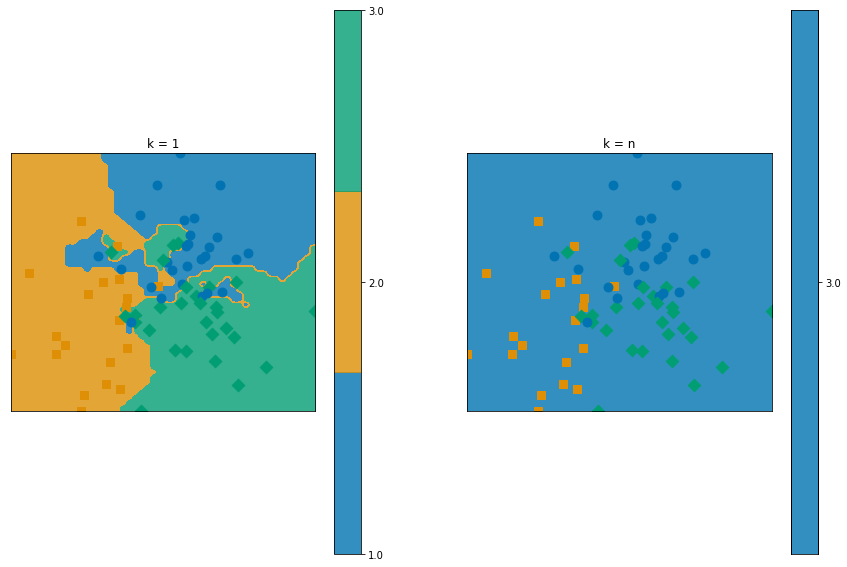

In [36]:
# affichage des deux cas extrêmes k=1 et k=n
plt.close("all")
plt.figure(figsize=(15, 10))
clf = KNeighborsClassifier(n_neighbors = 1)
clf.fit(X2[::2], y2[::2])
plt.subplot(121)
plt.title('k = 1')
ks.frontiere_new(f, X2[::2], y2[::2])
clf = KNeighborsClassifier(n_neighbors = 75)
clf.fit(X2[::2], y2[::2])
plt.subplot(122)
plt.title('k = n')
ks.frontiere_new(f, X2[::2], y2[::2])

Dans le cas extrême où k=1, le classificateur obtient un résultat parfait pour les données d'entrainement. En effet, on ne prend en compte qu'un voisin, et chaque donnée de l'échantillon a pour plus proche voisin elle-même: elle est donc classée selon sa propre étiquette, et le classificateur classe chaque observation correctement. Cela ne présage toutefois pas de l'efficacité du classificateur lorsqu'une nouvelle donnée sera ajoutée, puisqu'elle sera classée sur un seul voisin, ce qui est vraissemblablement trop peu pour une classification adéquate. Ce cas extrême est celui où la frontière est la plus complexe, puisqu'elle doit classer chaque observation correctement. C'est ce qu'on observe sur la première figure.

Dans le cas extrême où k=n avec n la taille de l'échantillon, la classification pour chaque observation se fait en prenant en compte l'ensemble des données. Toutes les données sont donc classées identiquement, en prenant simplement la classe majoritaire. C'est ce qu'on observe sur la seconde figure, où toutes les données sont classifiées en classe 1 (bleue). C'est le cas où la frontière est la plus simple.

7) Une variante possible très utilisée consiste à pondérer les poids du jème voisin selon $e^{-d_j^2/h}$ ($h$ contrôlant le niveau de pondération). Implémentez cette variante dans scikit-learn en passant le paramètre weights au constructeur de KNeighborsClassifier.

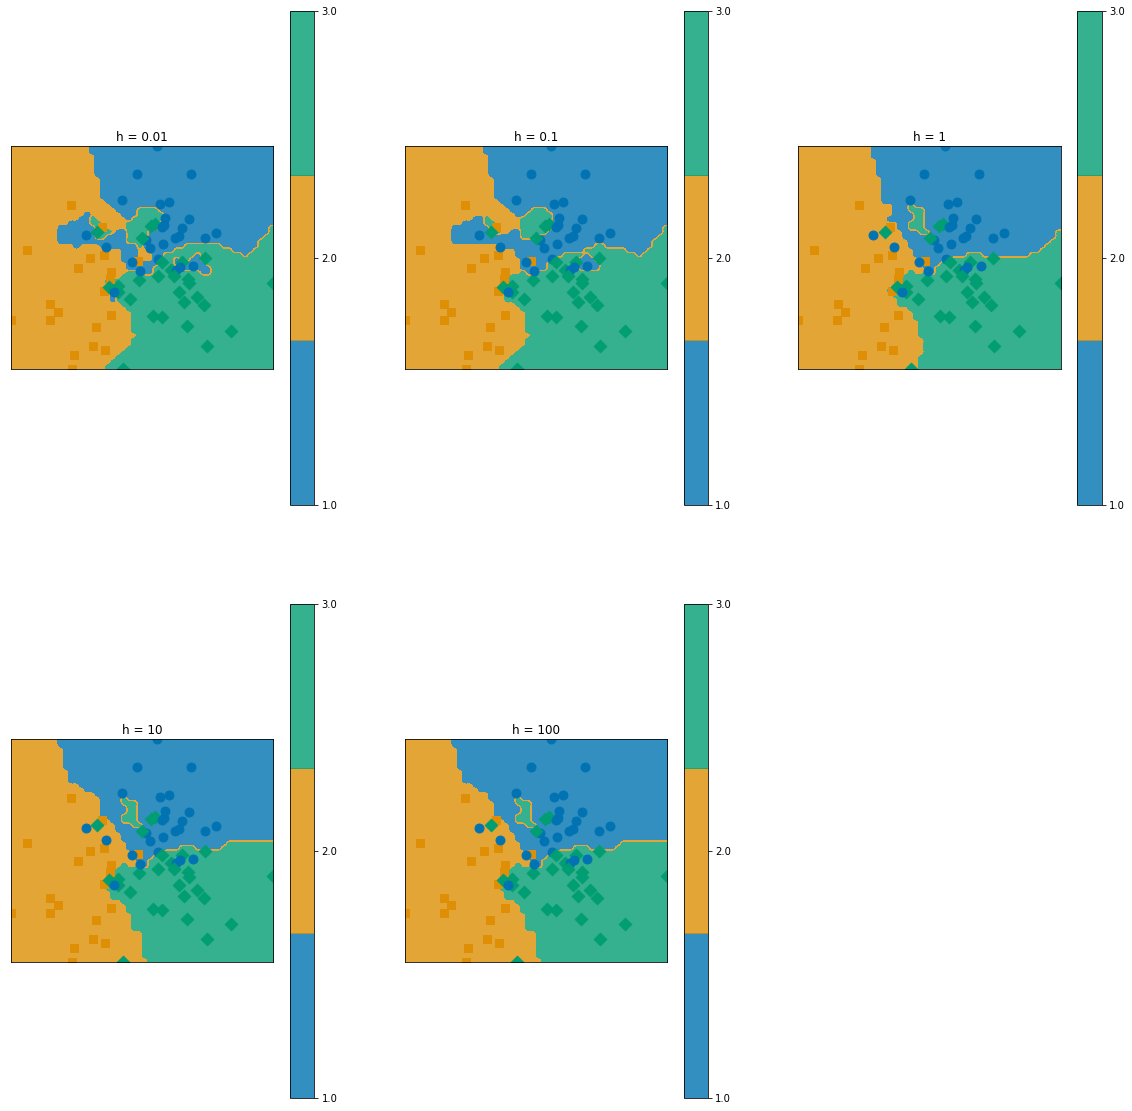

In [37]:
plt.close("all")
plt.figure(figsize=(20, 20))

# on définit la fonction de poids pour h=0.01
def weight(dist):
            h = 0.01
            w = np.exp(-dist**2 / h)
            return w
clf = KNeighborsClassifier(n_neighbors = 7, weights = weight)
clf.fit(X2[::2],y2[::2])      
plt.subplot(231)
plt.title('h = 0.01')
ks.frontiere_new(f, X2[::2], y2[::2])
         
# on définit la fonction de poids pour h=0.1
def weight(dist):
            h = 0.1
            w = np.exp(-dist**2 / h)
            return w
clf = KNeighborsClassifier(n_neighbors = 7, weights = weight)
clf.fit(X2[::2],y2[::2])      
plt.subplot(232)
plt.title('h = 0.1')
ks.frontiere_new(f, X2[::2], y2[::2])

# on définit la fonction de poids pour h=1
def weight(dist):
            h = 1
            w = np.exp(-dist**2 / h)
            return w
clf = KNeighborsClassifier(n_neighbors = 7, weights = weight)
clf.fit(X2[::2],y2[::2])      
plt.subplot(233)
plt.title('h = 1')
ks.frontiere_new(f, X2[::2], y2[::2])

# on définit la fonction de poids pour h=10
def weight(dist):
            h = 10
            w = np.exp(-dist**2 / h)
            return w
clf = KNeighborsClassifier(n_neighbors = 7, weights = weight)
clf.fit(X2[::2],y2[::2])      
plt.subplot(234)
plt.title('h = 10')
ks.frontiere_new(f, X2[::2], y2[::2])

# on définit la fonction de poids pour h=100
def weight(dist):
            h = 100
            w = np.exp(-dist**2 / h)
            return w
clf = KNeighborsClassifier(n_neighbors = 7, weights = weight)
clf.fit(X2[::2],y2[::2])      
plt.subplot(235)
plt.title('h = 100')
ks.frontiere_new(f, X2[::2], y2[::2])

On remarque que plus h est petit, plus la frontière est complexe. On peut regarder la formule du poids $w = exp(-d_j^2/h)$ pour comprendre celà. $h$ est en fait un terme de scaling pour la fonction de poids: lorsque $h$ est petit, $d_j^2/h$ tend à être grand, et donc $exp(-d_j^2/h)$ tend vers 0. Seules les très petites valeurs de $d_j$ résultent alors en un poids non zero. Autrement dit, on attribue du poids uniquement aux valeurs très proches. Cela est équivalent au cas où k=1, qui comme on l'a vu résulte en une frontière complexe. Inversement, lorsque $h$ est grand, la fonction $exp(-d_j^2/h)$ tend vers 1 quel que soit $d_j$, et on se rapproche du cas où il n'y a pas de pondération. La frontière est alors plus simple.

8) Quel est le taux d’erreur sur les mêmes données d’apprentissage (i.e., la proportion d’erreur faite par le classifieur) lorsque k = 1 ? et sur des données de test (les observations d’indice pair) ?

In [38]:
# entraînement avec k=1
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X2[::2], y2[::2])
clf_pred = clf.predict(X2[::2])
# taux d'erreur avec la fonction score
error_rate_train = 1 - clf.score(X2[::2],y2[::2])
error_rate_test = 1 - clf.score(X2[1::2],y2[1::2])
# affichage
print("Le taux d'erreur sur les données d'apprentissage est de " + str(round(100 * error_rate_train, 2)) + "%.")
print("Le taux d'erreur sur les données d'apprentissage est de " + str(round(100 * error_rate_test, 2)) + "%.")

Le taux d'erreur sur les données d'apprentissage est de 0.0%.
Le taux d'erreur sur les données d'apprentissage est de 32.0%.


Le taux d'erreur est de 0% sur les données d'apprentissage. Celà est logique car, encore une fois, le plus proche voisin de chaque donnée est elle-même, ce qui résulte en une classification parfaite. Pour l'échantillon de test, le taux d'erreur fluctue entre 20% et 30% environ (des variations se produisent selon la seed utilisée). Le taux est ici non-nul car les prédictions des données de test sont formées sur la plus proche distance des données d'apprentissage. La classification peut donc être imparfaite. Un résultat de 20-30% d'erreur est relativement élevé, ce qui indique qu'un seul voisin n'est peut être pas suffisant pour obtenir une bonne prédiction.

9) Pour le jeu de données #4, en utilisant les observations d’indice pair pour l’apprentissage et les observations d’indice impair pour le test, tracez le taux d’erreur en fonction de k pour k = 1, 2, . . . , 50. Vous pourrez utiliser la classe fournie ErrorCurve.

Le taux minimum d'erreur est obtenu lorsque k=3.


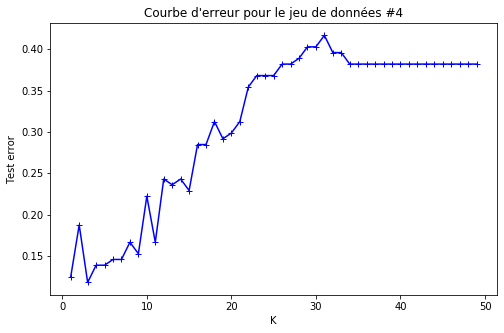

In [39]:
# on utilise la classe fournie ErrorCurve
plt.close("all")
ec = ks.ErrorCurve(k_range=list(range(1,50)))
ec.fit_curve(X4[::2],y4[::2],X4[1::2],y4[1::2])
plt.figure(figsize=(8, 5))
ec.plot(maketitle=False, marker='+',color='blue');
plt.title("Courbe d'erreur pour le jeu de données #4")
k_min_error = np.argmin(ec.errors) + 1 
print("Le taux minimum d'erreur est obtenu lorsque k=" + str(k_min_error) + ".")

10) Tracez les différentes courbes d’erreur en fonction du paramètre k = (1, 2, . . . , 50) sur le jeu de données #4, pour des nombres d’échantillons d’entrainement n prenant les valeurs 100, 200, 500 à 1000. Cette fois, tirez l’ensemble d’apprentissage et l’ensemble de test indépendamment et de même taille. Quelle est la meilleure valeur de k ? Est-ce la même pour les différents datasets ? Vous pourrez utiliser la classe fournie ErrorCurve. Pour n = 1000 visualisez les données et la règle de décision sur le même graphique. (Vous pouvez utiliser la fonction frontiere_new.)

Le taux minimum d'erreur pour n = 100 est obtenu lorsque k=3.
Le taux minimum d'erreur pour n = 200 est obtenu lorsque k=26.
Le taux minimum d'erreur pour n = 500 est obtenu lorsque k=9.
Le taux minimum d'erreur pour n = 1000 est obtenu lorsque k=13.


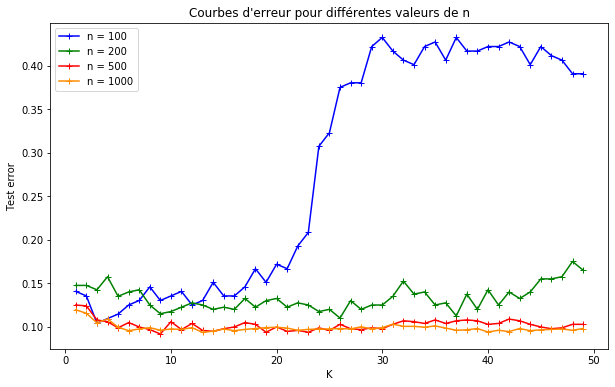

In [41]:
# preparation de la boucle et des paramètres graphiques
plt.close("all")
m=['+','+','+','+']
c=['blue','green','red','darkorange']
plt.figure(figsize=(10, 6))
sample_size = [100, 200, 500, 1000]
for count, size in enumerate(sample_size):
    # génération du jeu de données d'apprentissage
    n1 = size
    n2 = size
    sigma = 0.1
    X4_train, y4_train = ks.rand_checkers(n1, n2, sigma)
    X4_test, y4_test = ks.rand_checkers(n1, n2, sigma)
    # calcul de la courbe d'erreur
    ec = ks.ErrorCurve(k_range=list(range(1,50)))
    ec.fit_curve(X4_train,y4_train,X4_test,y4_test)
    lgd = 'n = ' + str(size)
    ec.plot(maketitle=False, marker=m[count],color=c[count],label=lgd);
    plt.legend()
    plt.title("Courbes d'erreur pour différentes valeurs de n")
    k_min_error = np.argmin(ec.errors) + 1
    print("Le taux minimum d'erreur pour n = " + str(size) + " est obtenu lorsque k=" + str(k_min_error) + ".")

On peut tirer globalement deux conclusions. D'abord, Le taux d'erreur tend globalement à décroître avec la taille de l'échantillon, et ce de façon significative. Alors que le taux d'erreur peut dépasser 40% avec un très petit échantillon de n=100, il fluctue autour de 10% pour l' échantillon le plus large à n=1000. Celà confirme que le nombre de données disponibles est crucial à l'efficacité du modèle. La seconde conclusion est que la meilleure valeur de k varie avec la taille de l'échantillon. Même si globalement le taux d'erreur tend d'abord à décroître lorsque k augmente, puis à remonter lorsque les valeurs de k deviennent trop grande, le meilleur k est différent pour chaque taille d'échantillon.

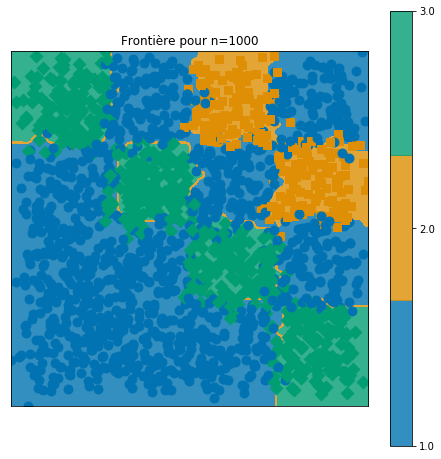

In [42]:
# traçage de la frontière pour le cas n=1000
plt.close("all")
plt.figure(figsize=(8, 8))
clf = KNeighborsClassifier(n_neighbors = k_min_error)
clf.fit(X4_train, y4_train)
plt.title('Frontière pour n=1000')
ks.frontiere_new(f, X4_train, y4_train)

On constate qu'avec un échantillon de grande taille (n=1000), les erreurs de classement deviennent rares. Le modèle obtient donc une meilleure performance à mesure que la taille du jeu de données augmente.

11) A votre avis, quels sont les avantages et les inconvénients de la méthode des plus proches voisins : temps de calcul ? passage à l’échelle ? interprétabilité ?

Le principal avantage de la méthode des plus proches voisins est sa simplicité et son interprétabilité. La méthode est extrêmement intuitive puisqu'elle consiste simplement à prendre une décision basée sur la proximité. Elle est aussi bien visualisable, comme le montrent les graphiques ci-dessus. Le temps de calcul et le passage à l'échelle représentent en revanche des limites de la méthode. En effet, le principal inconvénient de la méthode est qu'elle nécessite à chaque nouveau point de donnée de calculer sa distance avec tous les points du jeu d'entraînement. Pour un petit jeu d'entraînement, le temps de calcul sera limité, mais la précision sera faible. Pour un gros jeu de données, la précision sera bien meilleure, mais le temps de calcul peut devenir prohibitif. Le passage à l'échelle peut donc représenter une difficulté majeure de la méthode.

12) Étudiez la base digits de scikit-learn. On pourra se référer à http://scikit-learn.org/stable/ _downloads/plot_digits_classification.py pour le chargement et la manipulation de la base de données. Pour de plus amples informations sur la nature de la classe 'Bunch' (une sous-classe de dictionnaire, on se reportera à la documentation sur la classe 'dict' : http://docs.python.org/ 2/library/stdtypes.html#mapping-types-dict. Décrivez la nature et le format des données (précisément), affichez un exemple. Tracez l’histogramme pour des classes. Coupez l’échantillon en deux parties de même taille et utilisez la première partie pour l’apprentissage et la deuxième pour le test. Appliquez la méthode aux données issues de la base digits pour un choix de k ≥ 1 (e.g., k = 30) et indiquez le taux d’erreur.

La base est faite de données sur des images représentant des chiffres. Plus précisément, la base contient 1797 images représentant des chiffre de 0 à 9. Chaque image est de format 8 $\times$ 8 pixels en noir et blanc, que l'on représente par un vecteur de dimension 64 (une valeur par pixel qui représente l'intensité de noir du pixel concerné). C'est ce que l'on trouve dans la partie data de la base de données. La base de données contient aussi une partie target qui pour chaque image renvoie un entier: le chiffre effectivement représenté  par l'image. Dans le cadre de la classification, la partie data va donc représenter l'ensemble des features utilisés pour entraîner le modèle, et la partie target représente les étiquettes à prédire.

On peut affichier un premier exemple avec les quatre premières images de la base (on suit ici la documentation de la base de données digits):

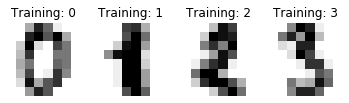

In [15]:
# chargement de la base et représentation des 4 premières images
digits = load_digits()
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

En termes de données numériques, on obtient la représentation suivante:

In [16]:
# représentation de la première donnée, en forme numérique
print("La représentation vectorielle des pixels de la première image est:")
print(digits.data[0])
print("La valeur cible de la première image est:")
print(digits.target[0])

La représentation vectorielle des pixels de la première image est:
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
La valeur cible de la première image est:
0


La base contient 10 classes (les chiffres de 0 à 9). Leur histogramme est donnée par:

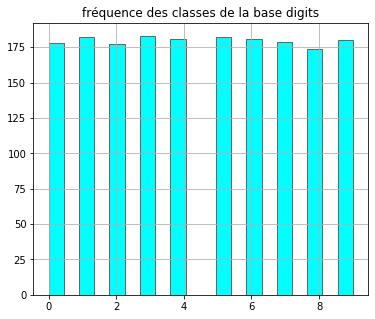

In [17]:
plt.close("all")
plt.figure(figsize=(6,5))
plt.hist(digits.target, bins = 20, color = "cyan", edgecolor=(0.4, 0.4, 0.4))
plt.title('fréquence des classes de la base digits')
plt.grid(True)
plt.show()

On remarque que les classes sont globalement équilibrées, chaque chiffre étant représenté plus ou moins à la même fréquence que les autres.

In [43]:
# séparation de l'échantillon en données d'apprentissage et de test
X_train = digits.data[::2]
y_train = digits.target[::2]
X_test = digits.data[1::2]
y_test = digits.target[1::2]
# estimation du modèle avec k=30
clf = KNeighborsClassifier(n_neighbors=30)
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
# taux d'erreur
error_rate_train = 1 - clf.score(X_train,y_train)
error_rate_test = 1 - clf.score(X_test,y_test)
print("Le taux d'erreur sur les données d'apprentissage est de " + str(round(100 * error_rate_train, 2)) + "%.")
print("Le taux d'erreur sur les données de test est de " + str(round(100 * error_rate_test, 2)) + "%.")

Le taux d'erreur sur les données d'apprentissage est de 4.0%.
Le taux d'erreur sur les données de test est de 5.57%.


On remarque deux choses. D'abord, le taux d'erreur est légèrement plus élevé sur le jeu de test que sur le jeu d'entraînement, comme on pouvait s'y attendre. Ensuite, on note que même une méthode aussi simple que les plus proches voisins produit de bonnes prédictions: le taux d'erreurs sur l'échantillon test fluctue aux alentours de 5% seulement (varie avec la seed utilisée).

13) Estimez la matrice de confusion (P{Y = i, Ck (X) = j})i, j associée au classifieur Ck ainsi obtenu et visualisez celle-ci. Pour la manipulation de telles matrices avec scikit-learn, on pourra consulter http://scikit-learn.org/stable/auto_examples/model_selection/plot_ confusion_matrix.html.

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.98876404 0.         0.         0.         0.
  0.01123596 0.         0.         0.        ]
 [0.01098901 0.01098901 0.92307692 0.         0.         0.
  0.         0.01098901 0.04395604 0.        ]
 [0.         0.         0.01075269 0.91397849 0.         0.02150538
  0.         0.02150538 0.03225806 0.        ]
 [0.         0.         0.         0.         0.98863636 0.
  0.         0.         0.01136364 0.        ]
 [0.         0.         0.         0.         0.         0.95604396
  0.01098901 0.         0.         0.03296703]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.05813953 0.02325581 0.01162791 0.         0.02325581
  0.01162791 0.         0.872093

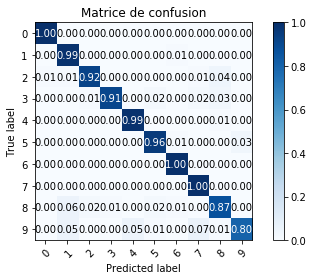

In [44]:
# affichage de la matrice de confusion (normalisée pour mieux visualiser les performances sur les différentes classes)
plot_confusion_matrix(y_test, clf_pred, classes=digits.target_names, normalize=True,
                      title='Matrice de confusion');

On remarque que les performances sont variables d'une classe à l'autre. Certaines classes sont très bien prédites (par exemple les classes 0, 6 et 7 qui bénéficient d'une prédiction parfaite) alors que d'autres ont des taux d'erreurs assez significatifs (par exemple la classe 9 qui atteint 20% d'erreur).

14) Proposez une méthode pour choisir k et mettez-la en œuvre. Vous pourrez utiliser la classe fournie LOOCurve. En utilisant toutes les données, tracez la courbe du taux d’erreur leave-one-out pour k = 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200. Pour plus d’information sur la validation croisée (cross- validation) on peut consulter [HTF09, Chapitre 7.10].

La méthode proposée est celle de la validation croisée: on découpe l'ensemble d'apprentissage en K folds ou partitions, puis entraine le modèle sur K-1 folds, utilisant la dernière fold comme échantillon test pour évaluer le modèle. En opérant une rotation des folds, on obtient K évaluations qu'on moyennise pour obtenir le risque du modèle. La méthode de validation croisée suggérée par la question, "leave one out", est un cas extrême de validation croisée où K=n, le nombre de données d'apprentissage. On entraîne ainsi n modèles sur toutes les données sauf une laissé à part comme donnée de test. On obtient ainsi la validation croisée la plus fine possible.

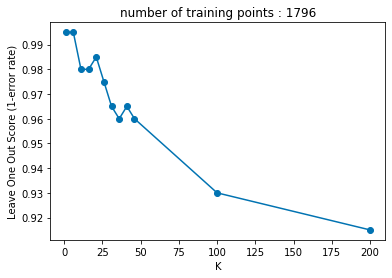

In [45]:
k_values = [1,6,11,16,21,26,31,36,41,46,100,200]
loo = ks.LOOCurve(k_range = k_values)
loo.fit_curve(digits.data, digits.target)
loo.plot()

In [21]:
print("Selon la méthode 'leave one out', le meilleur choix est k = " + str(k_values[np.argmax(loo.cv_scores)]) + ".")

Selon la méthode 'leave one out', le meilleur choix est k = 1.


## Analyse Discriminante Linéaire

15) En utilisant la formule de Bayes donner la formule des probabilités a posteriori : P{Y = +1 | X = x}, P{Y = −1 | X = x}, comme fonctions de f+ , f− et π+ .

La formule de Bayes donne:

$P\{Y = +1 | X = x\} = \frac{P \{ X = x | Y = +1 \} P \{ Y = +1 \}}{P \{ X = x \}}$

en considérant que $P \{ X = x \} = P \{ X = x | Y = +1 \} P \{ Y = +1 \} + P \{ X = x | Y = -1 \} P \{ Y = -1 \}$, et en notant que $P \{ Y = -1 \} = 1 - P \{ Y = +1 \} $ on obtient:

$P\{Y = +1 | X = x\} = \frac{P \{ X = x | Y = +1 \} P \{ Y = +1 \}}{P \{ X = x | Y = +1 \} P \{ Y = +1 \} + P \{ X = x | Y = -1 \} (1 - P \{ Y = +1 \})}$

et en substituant les définitions:

$P\{Y = +1 | X = x\} = \frac{f_+ \ \pi_+}{f_+ \ \pi_+ \ + \ f_- \ (1 - \pi_+)}$

On procède de même pour $P\{Y = -1 | X = x\}$ et on obtient:

$P\{Y = -1 | X = x\} = \frac{f_- \ (1 - \pi_+)}{f_+ \ \pi_+ \ + \ f_- \ (1 - \pi_+)}$

16) Exprimer le log-ratio des deux classes en fonction de π+ , µ+ , µ− et Σ.

On déroule simplement la formule:


$\log \left( \frac{P\{Y = 1 | X = x\}}{P\{Y = -1 | X = x\}} \right) = \log \left( \frac{f_+ \ \pi_+ \ / \ [f_+ \ \pi_+ \ + \ f_- \ (1 - \pi_+)]}{f_- \ (1 - \pi_+) \ / \ [f_+ \ \pi_+ \ + \ f_- \ (1 - \pi_+)]} \right) = \log \left( \frac{f_+ \ \pi_+ }{f_- \ (1 - \pi_+) } \right) = \log \left( \frac{f_+}{f_-} \right) + \log(\pi_+) - \log(1 - \pi_+)$

On simplifie le premier terme:

$\log \left( \frac{f_+}{f_-} \right) = \log \left( \frac{(2 \pi)^{-p/2} |\Sigma|^{-1/2} exp \left\{ -\frac{1}{2} (x - \mu_+)^T \Sigma^{-1} (x - \mu_+) \right\}}{(2 \pi)^{-p/2} |\Sigma|^{-1/2} exp \left\{ -\frac{1}{2} (x - \mu_-)^T \Sigma^{-1} (x - \mu_-) \right\}} \right) = \log \left( \frac{exp \left\{ -\frac{1}{2} (x - \mu_+)^T \Sigma^{-1} (x - \mu_+) \right\}}{exp \left\{ -\frac{1}{2} (x - \mu_-)^T \Sigma^{-1} (x - \mu_-) \right\}} \right)$

$= -\frac{1}{2} (x - \mu_+)^T \Sigma^{-1} (x - \mu_+) + \frac{1}{2} (x - \mu_-)^T \Sigma^{-1} (x - \mu_-)$ 

$= - \frac{1}{2} \left( x^T \Sigma^{-1} x + \mu_+^T \Sigma^{-1} \mu_+ - 2 x^T \Sigma^{-1} \mu_+ - x^T \Sigma^{-1} x - \mu_-^T \Sigma^{-1} \mu_- + 2 x^T \Sigma^{-1} \mu_- \right)$

$= - \frac{1}{2} \left( \mu_+^T \Sigma^{-1} \mu_+ - 2 x^T \Sigma^{-1} \mu_+ - \mu_-^T \Sigma^{-1} \mu_- + 2 x^T \Sigma^{-1} \mu_- \right)$

$= - \frac{1}{2} \left( \mu_+^T \Sigma^{-1} \mu_+ - \mu_-^T \Sigma^{-1} \mu_- - 2 x^T \Sigma^{-1} (\mu_+ - \mu_-) \right)$

$= - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- + x^T \Sigma^{-1} (\mu_+ - \mu_-)$

On renvoie dans la première expression pour obtenir:

$\log \left( \frac{P\{Y = 1 | X = x\}}{P\{Y = -1 | X = x\}} \right) = - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- + x^T \Sigma^{-1} (\mu_+ - \mu_-) + \log(\pi_+) - \log(1 - \pi_+)$

17) Justifier le choix du classifieur:

Comme pour tout classifieur binaire, on prédira $Y = 1$ si $P\{Y = 1 | X = x\} > P\{Y = -1 | X = x \}$. En partant de cette condition, on obtient:

$P\{Y = 1 | X = x\} > P\{Y = -1 | X = x \}$

$\Leftrightarrow \frac{P\{Y = 1 | X = x\}}{P\{Y = -1 | X = x \}}  > 1$

$\Leftrightarrow \log \left( \frac{P\{Y = 1 | X = x\}}{P\{Y = -1 | X = x \}} \right)  > 0$

$\Leftrightarrow - \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ + \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- + x^T \Sigma^{-1} (\mu_+ - \mu_-) + \log(\pi_+) - \log(1 - \pi_+) > 0$

$\Leftrightarrow x^T \Sigma^{-1} (\mu_+ - \mu_-)   > \frac{1}{2} \mu_+^T \Sigma^{-1} \mu_+ - \frac{1}{2} \mu_-^T \Sigma^{-1} \mu_- + \log(1 - \pi_+) - \log(\pi_+)$

Comme on utilise les estimateurs sans biais des paramètres, on obtient:

$\Leftrightarrow x^T \hat{\Sigma}^{-1} (\hat{\mu}_+ - \hat{\mu}_-)   > \frac{1}{2} \hat{\mu}_+^T \Sigma^{-1} \hat{\mu}_+ - \frac{1}{2} \hat{\mu}_-^T \hat{\Sigma}^{-1} \hat{\mu}_- + \log(1 - m/n) - \log(m/n)$

Ce qui correspond au classifieur proposé.

## Mise en oeuvre

18) Écrivez votre propre classe LDAClassifier avec les méthodes d’apprentissage fit et de classification predict.

In [22]:
class LDAClassifier(BaseEstimator, ClassifierMixin):

    def fit(self, X, y):
        # on définit les termes requis pour le classifieur
        n = len(y)
        m = len(y[y==1])
        pi_hat_p = m/n
        X_p = X[y==1,:]
        X_m = X[y==-1,:]
        mu_hat_p = X_p.sum(axis = 0) / m
        mu_hat_m = X_m.sum(axis = 0) / (n - m)
        Sigma_hat_p = (X_p - mu_hat_p).transpose() @ (X_p - mu_hat_p) / (m - 1)
        Sigma_hat_m = (X_m - mu_hat_m).transpose() @ (X_m - mu_hat_m) / (n - m - 1)
        Sigma_hat = ((m - 1) * Sigma_hat_p + (n - m - 1) * Sigma_hat_m) / (n - 2)
        inv_Sigma_hat = np.linalg.inv(Sigma_hat)
        # on calcule les côtés droit et gauche de l'inégalité de classification
        self.rhs = 0.5 * (np.transpose(mu_hat_p) @ inv_Sigma_hat @ mu_hat_p - np.transpose(mu_hat_m) @ inv_Sigma_hat @ mu_hat_m) + np.log(1 - m / n) - np.log(m / n)
        self.lhs = inv_Sigma_hat @ (mu_hat_p - mu_hat_m)
        return self
    
    def predict(self, X):
        y_pred = []
        # pour chaque nouvelle donnée, on classifie selon le résultat de l'inégalité de classification
        for row in range(len(X)):
            x = X[row,:]
            classification = np.transpose(x) @ self.lhs - self.rhs
            if classification > 0:
                y_pred.append(1)
            else:
                y_pred.append(-1)
        return np.array(y_pred)

19) Importez le module sklearn.discriminant_analysis qui contient en particulier la classe LinearDiscriminantAnalysis qui nous servira dans la suite. Vérifiez la validité des résultats obtenus avec votre méthode en les comparant à ceux de la classe LinearDiscriminantAnalysis de scikit-learn en utilisant un jeu de données simulé. Vous proposerez votre propre méthode de comparaison (l’échantillon d’apprentissage doit être petit et l’échantillon de validation doit être assez grand ; on considère par ailleurs que m est différent de n − m, i.e., les deux classes ne sont pas représentées par le même nombre d’échantillons observés). Indiquez les taux d’erreur de LDAClassifier et de LinearDiscriminantAnalysis et le nombre de cas où les prédictions coïncident. En utilisant votre classe LDAClassifier, visualisez la règle de classification. (Vous pouvez utiliser la fonction frontiere_new.)

On va d'abord simuler un nouveau jeu de données. J'utilise pour celà la méthode rand_clown, celle du troisième jeu de données. Comme demandé par l'énoncé, on va prendre un échantillon d'apprentissage petit et un échantillon de validation qui sera grand. Celà est inhabituel car on demande normalement plutôt d'entraîner le modèle sur un échatillon large, et de tester/valider sur un échantillon plus petit. Ici, on choisira de générer en tout 300 points de données: 100 pour l'échantillon d'apprentissage, et 200 pour l'échantillon test. Comme on veut que les classes aient un nombre différents d'occurences observées, on fixera m = 100 et donc n - m = 200. On partitionnera de façon aléatoire.

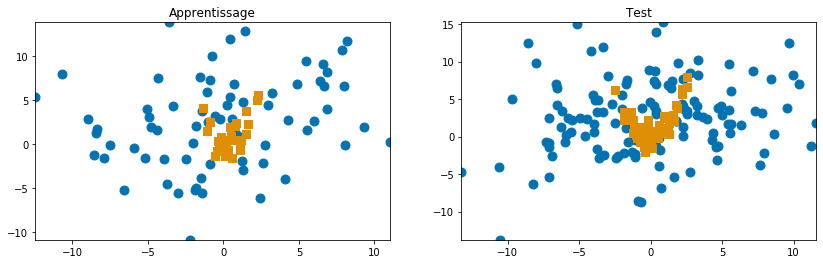

In [46]:
# on génère un cinquième jeu de données
n1 = 100
n2 = 200
sigmas1 = 1
sigmas2 = 5
X5, y5 = ks.rand_clown(n1, n2, sigmas1, sigmas2)
# on partitionne aléatoirement en apprentissage et test
X5_train, X5_test, y5_train, y5_test = model_selection.train_test_split(X5, y5, test_size=2/3, random_state = 0)
# graphiques des jeux d'apprentissage et de test
plt.close("all")
plt.figure(figsize=(14, 4))
# graphique du premier jeu de données
plt.subplot(121)
plt.title('Apprentissage')
ks.plot_2d(X5_train, y5_train)
plt.subplot(122)
plt.title('Test')
ks.plot_2d(X5_test, y5_test)

On va maintenant comparer les résultats obtenus entre la classe LDAClassifier faite à la main et la classe LinearDiscriminantAnalysis de Scikit Learn. On va comparer de manière simple, en observant si les prédictions fournies par les deux classes sont identiques. On comparera aussi les taux d'erreur obtenus par les deux classes.

In [48]:
# on commence avec la classe faite main, LDAClassifier
lda = LDAClassifier()
lda.fit(X5_train, y5_train)
pred_1 = lda.predict(X5_test)
# on continue avec la classe de Scikit Learn
lda = LinearDiscriminantAnalysis()
lda.fit(X5_train, y5_train)
pred_2 = lda.predict(X5_test)
# comparaison entre les deux prédictions
print("Les prédictions fournies par les classes LDAClassifier et LinearDiscriminantAnalysis sont-elles similaires?")
print()
print(pred_1 == pred_2)
# comparaison entre les deux taux d'erreur
error_rate_1 = np.count_nonzero(pred_1 != y5_test) / y5_test.size
error_rate_2 = 1 - lda.score(X5_test,y5_test)
# affichage
print()
print("Le taux d'erreur avec la classe LDAClassifier est de " + str(round(100 * error_rate_1, 2)) + "%.")
print("Le taux d'erreur avec la classe LinearDiscriminantAnalysis est de " + str(round(100 * error_rate_2, 2)) + "%.")

Les prédictions fournies par les classes LDAClassifier et LinearDiscriminantAnalysis sont-elles similaires?

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  T

On observe que les prévisions coincident dans tous les cas, et que les taux d'erreurs sont également identiques.

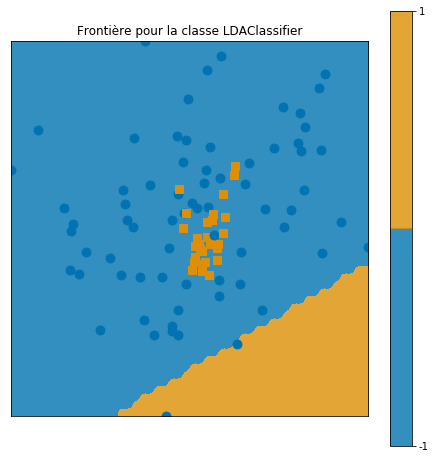

In [49]:
# traçage de la frontière
plt.close("all")
plt.figure(figsize=(8, 8))
lda = LDAClassifier()
lda.fit(X5_train, y5_train)
lda.predict(X5_train)
plt.title('Frontière pour la classe LDAClassifier')
def g(x):
    return lda.predict(x.reshape(1,-1))
ks.frontiere_new(g, X5_train, y5_train)

20) En utilisant votre classe LDAClassifier, visualisez la règle de classification pour les jeux de données #1 et #3. (Vous pouvez utiliser la fonction frontiere_new.) Discutez l’efficacité de la méthode dans ces deux cas.

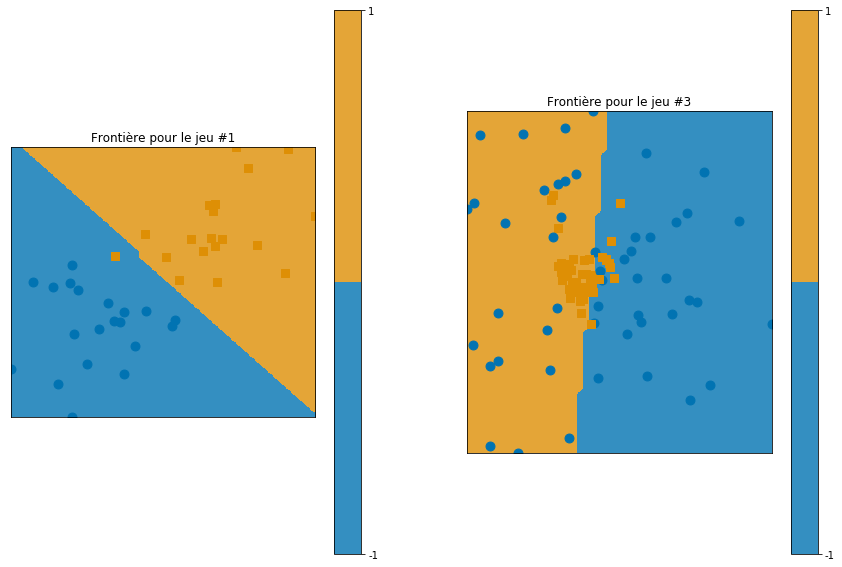

In [50]:
# traçage de la frontière pour le jeu #1
plt.close("all")
plt.figure(figsize=(15, 10))
lda = LDAClassifier()
lda.fit(X1, y1)
lda.predict(X1)
plt.subplot(121)
plt.title('Frontière pour le jeu #1')
ks.frontiere_new(g, X1, y1)
# traçage de la frontière pour le jeu #3
lda = LDAClassifier()
lda.fit(X3, y3)
lda.predict(X3)
plt.subplot(122)
plt.title('Frontière pour le jeu #3')
ks.frontiere_new(g, X3, y3)

Dans le cas du jeu de données #1, la méthode s'avère très efficace. Comme on peut le voir sur le graphique, la séparation entre les classes est très nette et seules quelques données sont mal classifiées. Celà est dû à la construction du jeu de données #1, qui est bâti sur deux distributions gaussiennes (bivariées) nettement séparées et de variance égales. Autrement dit, la forme réelle du jeu de données #1 correspond parfaitement à la forme supposée par la méthode de l'analyse discriminante linéaire, ce qui amène de très bons résultats prédictifs. Le jeu de données #3, à l'inverse, est basé sur la classe rand_clown dont la construction est très éloignées d'un couple de gaussiennes séparées et de variance égale. On peut remarquer deux distributions bien distinctes: les valeurs positives, très concentrées au milieu du graphique (autrement dit, venant d'une distribution à faible variance), et les valeurs négatives en bleu avec plus ou moins le même point central, mais une dispersion très forte. On viole donc les deux hypothèses de la LDA: au lieu de deux distributions à moyennes distinctes mais variance égale, on obtient deux distributions à moyenne proches, mais variance très différentes. Sans surprise, les performances prédictives sont plutot mauvaises car on ne respecte pas la forme supposée par le modèle. De nombreux points bleus sont mal classés, de même que quelques points orange. On voit donc à travers cet exemple l'importance d'utiliser un modèle pour lequel les données sont en accord avec les hypothèses sous-jacentes, sous peine de médiocres performances prédictives.

## Regression logistique

21) Appliquez la classification par régression logistique sur les données rand_bi_gauss. Comparer les résultats avec la LDA, notamment lorsque une classe est beaucoup plus petite que l’autre (a beaucoup moins d’observations). On parle alors de classes déséquilibrées.

On va construire deux nouveaus jeux de données avec la classe rand_bi_gauss. Pour obtenir une meilleure robustesse des résultats, on augmente le nombre totale de données à 200. Le premier jeu sera équilibré, avec 100 valeurs dans chaque catégorie, alors que le second sera très déséquilibré avec seulement 20 données dans la première catégorie, et 180 dans la seconde.

In [51]:
# construction des jeux de données
n1 = 100
n2 = 100
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
X6, y6 = ks.rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)
n1 = 20
n2 = 180
X7, y7 = ks.rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)
# classification avec LDA du jeu équilibré
lda = LDAClassifier()
lda.fit(X6, y6)
pred = lda.predict(X6)
error_rate_1 = np.count_nonzero(pred != y6) / y6.size
# classification avec regression logistique du jeu équilibré
lr = LogisticRegression()
lr.fit(X6, y6)
pred = lr.predict(X6)
error_rate_2 = 1 - lr.score(X6, y6)
# affichage
print("Le taux d'erreur avec l'analyse discriminante linéaire et le jeu équilibré est de " + str(round(100 * error_rate_1, 2)) + "%.")
print("Le taux d'erreur avec la régression logistique et le jeu équilibré est de " + str(round(100 * error_rate_2, 2)) + "%.")

Le taux d'erreur avec l'analyse discriminante linéaire et le jeu équilibré est de 3.5%.
Le taux d'erreur avec la régression logistique et le jeu équilibré est de 3.0%.


Avec un jeu de données équilibré, les deux méthodes fournissent des résultats très proches.

In [53]:
# classification avec LDA du jeu déséquilibré
lda = LDAClassifier()
lda.fit(X7, y7)
pred = lda.predict(X7)
error_rate_1 = np.count_nonzero(pred != y7) / y7.size
# classification avec regression logistique du jeu déséquilibré
lr = LogisticRegression()
lr.fit(X7, y7)
pred = lr.predict(X7)
error_rate_2 = 1 - lr.score(X7, y7)
# affichage
print("Le taux d'erreur avec l'analyse discriminante linéaire et le jeu déséquilibré est de " + str(round(100 * error_rate_1, 2)) + "%.")
print("Le taux d'erreur avec la régression logistique et le jeu déséquilibré est de " + str(round(100 * error_rate_2, 2)) + "%.")

Le taux d'erreur avec l'analyse discriminante linéaire et le jeu déséquilibré est de 3.0%.
Le taux d'erreur avec la régression logistique et le jeu déséquilibré est de 3.0%.


Même avec des classes déséquilibrées, les deux méthodes fournissent des résultats très proches. Cela vient encore, je suppose, de la construction de la classe rand_bi_gauss qui rend la séparation aisée entre les deux classes générées. De ce fait, quelle que soit la méthode choisie, le classificateur fournit de bonnes performances.

22) À quoi correspond la variable coef_ du modèle ? intercept_ ?

In [55]:
# extraction des coefficients
coeff = lr.coef_
intcpt = lr.intercept_
print("La valeur des coefficients de la regression est respectivement de " + str(round(lr.coef_[0][0], 2)) + " et " + str(round(lr.coef_[0][1], 2)) + ", tandis que celle de l'intercept est de " + str(round(intcpt[0], 2)) + ".")
print("Ils donnent l'équation d'un hyperplan séparateur dans R2 représentable comme une fonction linéaire avec ordonnée à l'origine " + str(round(- lr.coef_[0][0] / intcpt[0], 2)) + " et pente " + str(round(- lr.coef_[0][0] / lr.coef_[0][1], 2)) + ".")

La valeur des coefficients de la regression est respectivement de 1.61 et 1.8, tandis que celle de l'intercept est de -1.59.
Ils donnent l'équation d'un hyperplan séparateur dans R2 représentable comme une fonction linéaire avec ordonnée à l'origine 1.02 et pente -0.89.


Ces coefficients peuvent s'interpréter comme l'équation d'un hyperplan séparateur de données dans $R^2$. En ce sens, la régression logistique est comparable à un séparateur linéaire comme le perceptron, qui classe les données selon une position vis-à-vis de l'hyperplan.

23) Utiliser la fonction frontiere_new pour visualiser la frontière de décision.

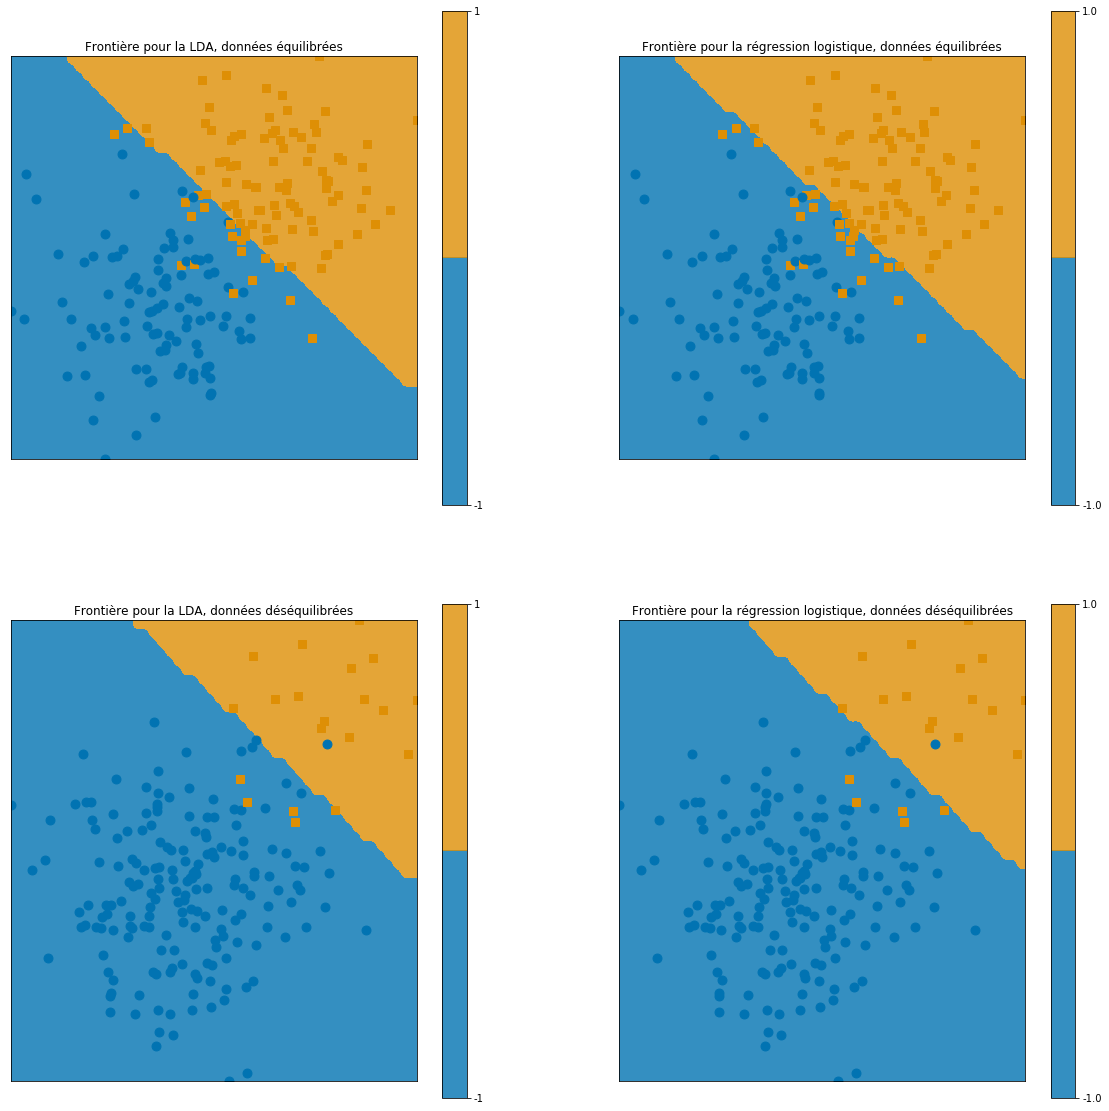

In [56]:
# traçage de la frontière pour les jeux équilibrés
def h(x):
    return lr.predict(x.reshape(1,-1))
plt.close("all")
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.title('Frontière pour la LDA, données équilibrées')
ks.frontiere_new(g, X6, y6)
plt.subplot(222)
plt.title('Frontière pour la régression logistique, données équilibrées')
ks.frontiere_new(h, X6, y6)
# traçage de la frontière pour les jeunx déséquilibrés
plt.subplot(223)
plt.title('Frontière pour la LDA, données déséquilibrées')
ks.frontiere_new(g, X7, y7)
plt.subplot(224)
plt.title('Frontière pour la régression logistique, données déséquilibrées')
ks.frontiere_new(h, X7, y7)

Les graphiques confirment les conclusions précédentes: les deux méthodologies produisent des performances très proches, même dans le cas de données très déséquilibrées. On remarque que les frontières induites sont très similaires, même si les méthodologies se basent sur des méthodes très différentes.

24) Appliquez la classification par régression logistique à des données issues de la base digits. Comme précédemment, coupez l’échantillon en deux parties de même taille et utilisez la première partie pour l’apprentissage et la deuxième pour tester. Indiquez le taux d’erreur.

In [58]:
# séparation de l'échantillon en données d'apprentissage et de test
X_train = digits.data[::2]
y_train = digits.target[::2]
X_test = digits.data[1::2]
y_test = digits.target[1::2]
# apprentissage du modèle
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
error_rate = 1 - lr.score(X_test, y_test)
# affichage
print("Le taux d'erreur sur l'échantillon test est de " + str(round(100 * error_rate, 2)) + "%.")

Le taux d'erreur sur l'échantillon test est de 6.01%.


Les résultats obtenus avec la régression logistique sont bons, avec des taux d'erreur autour de 5% (variant selon la seed). Un modèle simple peut donc obtenir de bonnes performances, même sur des questions complexes comme la reconnaissance d'images.